Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
from datetime import date, datetime

from pathlib import Path
from typing import Tuple
import subprocess
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, accuracy_score, precision_score
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, classification_report, recall_score

from scipy.stats import norm

import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv1D, Conv2D, AveragePooling2D, SeparableConv2D, BatchNormalization, Input
from keras.layers import Dropout, Add, Lambda, DepthwiseConv2D, Input, Permute, Flatten, AveragePooling1D, MaxPooling1D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.constraints import max_norm

2024-05-03 12:04:58.933970: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utility Functions 

Import data and Model evaluation/visualzation code below is based off of:
https://github.com/luciaquirke/sleep-apnea/tree/master

Many thanks to Lucia Quirke.

Data can imported from here:
https://virginia.box.com/s/5309m2ta8515d8wq8x9fq4j90hli3wmf


In [2]:
def setup_directory():
    data_path = Path('data/physionet.org/files/slpdb/1.0.0')

    targets_path = Path('data/targets/')
    inputs_path = Path('data/inputs')

    data_path.mkdir(parents=True, exist_ok=True)
    inputs_path.mkdir(parents=True, exist_ok=True)
    targets_path.mkdir(parents=True, exist_ok=True)

    print('Directories set up!')
    return inputs_path.absolute(), targets_path.absolute(), data_path.absolute()

# loads data from a single .csv file
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def evaluate_model(accuracy, y_test, y_pred):
    # calculate accuracy as a percentage
    accuracy = accuracy * 100.0
    print('Accuracy =', accuracy, "%")

    # generate confusion matrix
    matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    print('Confusion Matrix:')
    print(np.matrix(matrix))

    # calculate d'
    tp, fn, fp, tn = matrix.ravel()
    dprime = norm.ppf(tn/(tn+fp)) - norm.ppf(fn/(tp+fn))
    print('dPrime =', dprime)

    # generate classification report
    target_names = ['non-apnea', 'apnea']
    print('Classification Report:')
    print(classification_report(y_test.argmax(axis=1),
          y_pred.argmax(axis=1), target_names=target_names))

def visualise_training(history):
    # access the accuracy and loss values found throughout training
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    # plot accuracy throughout training (validation and training)
    plt.plot(epochs, acc, color='xkcd:azure')
    plt.plot(epochs, val_acc, color='xkcd:green')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.figure()

    # plot loss throughout training (validation and training)
    plt.plot(epochs, loss, color='xkcd:azure')
    plt.plot(epochs, val_loss, color='xkcd:green')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.figure()

    # plot accuracy throughout training (just training)
    plt.plot(epochs, acc, 'b')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.figure()

    # plot loss throughout training (just training)
    plt.plot(epochs, loss, 'b')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()


## Model Definition and Architecture

Temporal Convolutional Network code is based off of:
https://github.com/iis-eth-zurich/eeg-tcnet


In [3]:
# NEW MODEL

def EEGTCNet(nb_classes,
             Chans=64, 
             Samples=128, 
             layers=3, 
             kernel_s=10,
             filt=10, 
             dropout=0, 
             activation='relu', 
             F1=4, 
             D=2, 
             kernLength=64, 
             dropout_eeg=0.1,
             first_filt=40, 
             first_kernel=125, 
             first_pool=10,
             second_filt=40,
             second_kernel=50,
             second_pool=5,
             third_filt=60,
             third_kernel=10,
             third_pool=5, 
             temporal_dr=20):
    
    input1 = Input(shape = (Samples,Chans))
    
    F2= 50 * 1

    EEGNet_sep = EEGNet(input_layer=input1, 
                        first_filt=first_filt, 
                        first_kernel=first_kernel, 
                        first_pool=first_pool,
                        second_filt=second_filt,  
                        second_kernel=second_kernel, 
                        second_pool=second_pool, 
                        third_filt=third_filt, 
                        third_kernel=third_kernel, 
                        third_pool=third_pool, 
                        dropout=dropout)
    
    block2 = Lambda(lambda x: x[:,:,np.newaxis])(EEGNet_sep)
    outs = TCN_block(input_layer=block2, 
                     input_dimension=F2, 
                     depth=layers, 
                     kernel_size=kernel_s, 
                     filters=filt,
                     dropout=dropout,
                     activation=activation,
                     dr=temporal_dr)
    out = Lambda(lambda x: x[:,-1,:])(outs)
    dense = Dense(2, name = 'dense')(out)
    softmax = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1,outputs=softmax)

def EEGNet(input_layer, 
           first_filt=20, 
           first_kernel=125, 
           first_pool=10,
           second_filt=40,  
           second_kernel=50, 
           second_pool=5, 
           third_filt=60,
           third_kernel=10,
           third_pool=5,
           dropout=.3):
    
    # Convolutional Layer 1
    block1 = Conv1D(filters=first_filt, kernel_size=first_kernel, input_shape=(7500, 1))(input_layer)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = MaxPooling1D(pool_size=first_pool)(block1)
    block1 = Dropout(dropout)(block1)

    # Convolutional Layer 2
    block2 = Conv1D(filters=second_filt, kernel_size=second_kernel)(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = MaxPooling1D(pool_size=second_pool)(block2)
    block2 = Dropout(dropout)(block2)

    # Convolutional Layer 3
    block3 = Conv1D(filters=third_filt, kernel_size=third_kernel)(block2)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)
    block3 = MaxPooling1D(pool_size=third_pool)(block3)
    block3 = Dropout(dropout)(block3)
    block3 = Flatten()(block3)

    return block3

def TCN_block(input_layer,input_dimension,depth,kernel_size,filters,dropout,activation='elu', dr=1):
    
    block = Conv1D(filters, kernel_size=kernel_size, dilation_rate=dr, activation='linear',
                   padding = 'causal', kernel_initializer='he_uniform')(input_layer)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=dr,activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
    block = BatchNormalization()(block)
    block = Activation(activation)(block)
    block = Dropout(dropout)(block)
    
    if(input_dimension != filters):
        conv = Conv1D(filters,kernel_size=1,padding='same')(input_layer)
        added = Add()([block,conv])
    else:
        added = Add()([block,input_layer])
    out = Activation(activation)(added)
    
    for i in range(depth-1):
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(out)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        block = Conv1D(filters,kernel_size=kernel_size,dilation_rate=2**(i+1),activation='linear',
                   padding = 'causal',kernel_initializer='he_uniform')(block)
        block = BatchNormalization()(block)
        block = Activation(activation)(block)
        block = Dropout(dropout)(block)
        added = Add()([block, out])
        out = Activation(activation)(added)
        
    return out


In [4]:
model = EEGTCNet(2,
                 Chans=1, 
                 Samples=7500, 
                 layers=2, 
                 kernel_s=10,
                 filt=10, 
                 dropout=.3, 
                 activation='leaky_relu', 
                 F1=1875, D=1, 
                 kernLength=10, 
                 dropout_eeg=0.4, 
                 temporal_dr=2000, 
                 first_filt=50,
                 first_kernel=300, 
                 first_pool=12,
                 second_filt=80,  
                 second_kernel=50, 
                 second_pool=4, 
                 third_filt=50,
                 third_kernel=20, 
                 third_pool=4)

model.summary()

2024-05-03 12:05:02.847796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46586 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7500, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 7201, 50)             15050     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 7201, 50)             200       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 7201, 50)             0         ['batch_normalization[0][0

## Read in Data

In [5]:
inputs_path, targets_path, _ = setup_directory()

X_full, y_full = [], []

X_val, y_val  = [], []

X_test, y_test = [], []

print("Loading Data...")

for _, _, files in os.walk(os.path.join(inputs_path)):
    for filename in files:
        patient = filename.split("_")[0]

        if patient == '10': #randomly chosen single patient for validation set
            X_val.append(load_file(os.path.join(inputs_path, filename)))
            y_val.append(load_file(os.path.join(targets_path, filename)))

        elif (patient == '17' or patient == '11'): #Randomly chosen patients for test set
            X_test.append(load_file(os.path.join(inputs_path, filename)))
            y_test.append(load_file(os.path.join(targets_path, filename)))

        else:
            X_full.append(load_file(os.path.join(inputs_path, filename)))
            y_full.append(load_file(os.path.join(targets_path, filename)))

Directories set up!
Loading Data...


In [6]:
X = np.stack(X_full, axis=0)
Y = y_full

X_v = np.stack(X_val, axis=0)
Y_v = np.array(y_val)

X_t = np.stack(X_test, axis=0)
Y_t = np.array(y_test)

train_mean = np.mean(X)
train_std = np.std(X)

standardize_patients = lambda x: (x - train_mean) /  train_std

X = standardize_patients(X)
X_v = standardize_patients(X_v)
X_t = standardize_patients(X_t)


Y = np.array(Y)


Y = to_categorical(Y)
Y = Y.reshape(-1, 2)
    

Y_v = to_categorical(Y_v)
Y_v = Y_v.reshape(-1, 2)

Y_t = to_categorical(Y_t)
Y_t = Y_t.reshape(-1, 2)

In [12]:
BATCH_SIZE, SHUFFLE_BUFFER_SIZE  = 16, 1000

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).shuffle(SHUFFLE_BUFFER_SIZE, seed=123).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_v, Y_v)).batch(BATCH_SIZE)

print("Data Ready")

Data Ready


## Model Training

In [13]:
verbose, epochs, batch_size = 1, 50, 16

model = EEGTCNet(2,
                 Chans=1, 
                 Samples=7500, 
                 layers=2, 
                 kernel_s=10,
                 filt=10, 
                 dropout=.3, 
                 activation='leaky_relu', 
                 F1=1875, D=1, 
                 kernLength=10, 
                 dropout_eeg=0.4, 
                 temporal_dr = 2000, 
                 first_filt=50, 
                 first_kernel=300, 
                 first_pool=12,
                 second_filt=80,  
                 second_kernel=50, 
                 second_pool=4, 
                 third_filt=50,
                 third_kernel=20, 
                 third_pool=4)

callbacks =  [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
             ,tf.keras.callbacks.ModelCheckpoint('Model Checkpoints/checkpoint.model.h5', save_best_only=True, monitor='val_AUC', mode='max')
             ]


model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer='adam', 
              metrics=['accuracy'
                      ,tf.keras.metrics.AUC(curve='ROC', name='AUC', num_thresholds=10000)
                      ,tf.keras.metrics.AUC(curve='PR', name='AUPRC', num_thresholds=10000)
                      ,tf.keras.metrics.F1Score(name='F1', threshold=.4)])

tf.keras.utils.set_random_seed(7)

# train model
history = model.fit(train_dataset, 
                    epochs=epochs, 
                    verbose=verbose, 
                    validation_data=valid_dataset, 
                    callbacks=callbacks, class_weight={0:.4,1:.6}
                   )

Epoch 1/50
518/518 [==============================] - 11s 12ms/step - loss: 0.3200 - accuracy: 0.6309 - AUC: 0.6671 - AUPRC: 0.6478 - F1: 0.6256 - val_loss: 0.7896 - val_accuracy: 0.2063 - val_AUC: 0.1865 - val_AUPRC: 0.3402 - val_F1: 0.5889 - lr: 0.0010
Epoch 2/50
  6/518 [..............................] - ETA: 5s - loss: 0.3160 - accuracy: 0.6771 - AUC: 0.6954 - AUPRC: 0.6679 - F1: 0.6133 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


518/518 [==============================] - 6s 11ms/step - loss: 0.3085 - accuracy: 0.6768 - AUC: 0.7167 - AUPRC: 0.6936 - F1: 0.6359 - val_loss: 0.8421 - val_accuracy: 0.2063 - val_AUC: 0.1988 - val_AUPRC: 0.3451 - val_F1: 0.5054 - lr: 0.0010
Epoch 3/50
518/518 [==============================] - 6s 11ms/step - loss: 0.3081 - accuracy: 0.6839 - AUC: 0.7204 - AUPRC: 0.6957 - F1: 0.6380 - val_loss: 0.8164 - val_accuracy: 0.2063 - val_AUC: 0.1968 - val_AUPRC: 0.3439 - val_F1: 0.5763 - lr: 0.0010
Epoch 4/50
518/518 [==============================] - 6s 11ms/step - loss: 0.3053 - accuracy: 0.6757 - AUC: 0.7233 - AUPRC: 0.7055 - F1: 0.6404 - val_loss: 0.8155 - val_accuracy: 0.2063 - val_AUC: 0.1922 - val_AUPRC: 0.3419 - val_F1: 0.5782 - lr: 0.0010
Epoch 5/50
518/518 [==============================] - 6s 11ms/step - loss: 0.3055 - accuracy: 0.6802 - AUC: 0.7267 - AUPRC: 0.7052 - F1: 0.6443 - val_loss: 0.8808 - val_accuracy: 0.2063 - val_AUC: 0.1979 - val_AUPRC: 0.3442 - val_F1: 0.2858 - lr: 0.

## Results

39/39 [==============================] - 0s 3ms/step
Accuracy = 85.06972789764404 %
Confusion Matrix:
[[980  10]
 [172  57]]
dPrime = 1.6446453463251105
Classification Report:
              precision    recall  f1-score   support

   non-apnea       0.85      0.99      0.92       990
       apnea       0.85      0.25      0.39       229

    accuracy                           0.85      1219
   macro avg       0.85      0.62      0.65      1219
weighted avg       0.85      0.85      0.82      1219



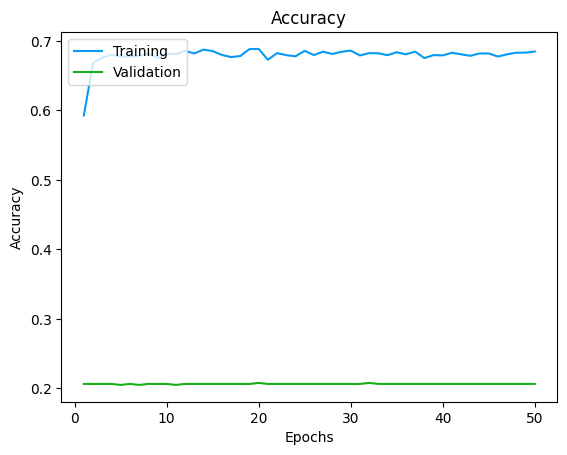

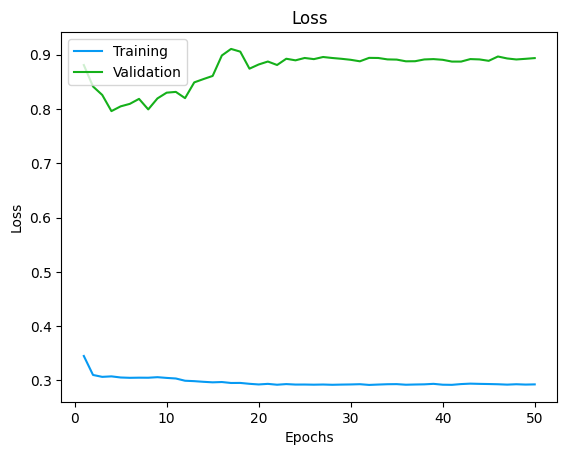

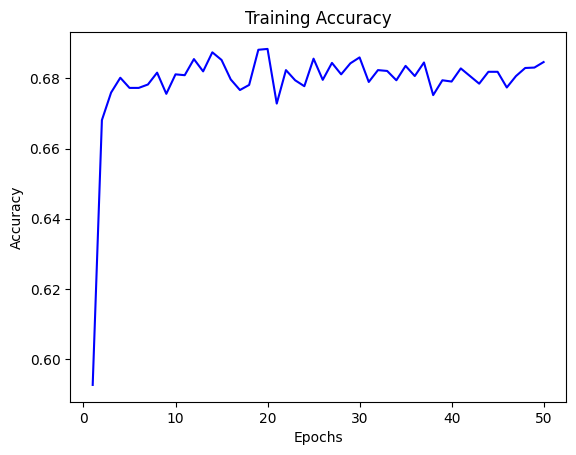

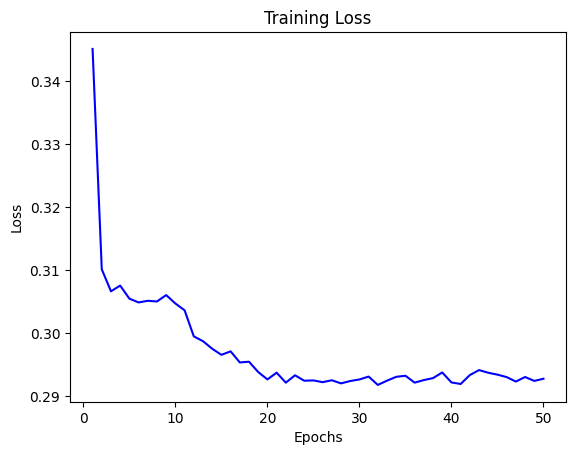

In [10]:
# test model and return accuracy
loss, accuracy, AUC, auprc, f1 = model.evaluate(X_t, Y_t, batch_size=batch_size, verbose=0)

# find predictions model makes for test set
y_pred = model.predict(X_t)

# Show model metrics such as Confusion Matrix, and classification Report
evaluate_model(accuracy, Y_t, y_pred)

# Visualize training history metrics such as train/validation accuracy & loss
visualise_training(history)

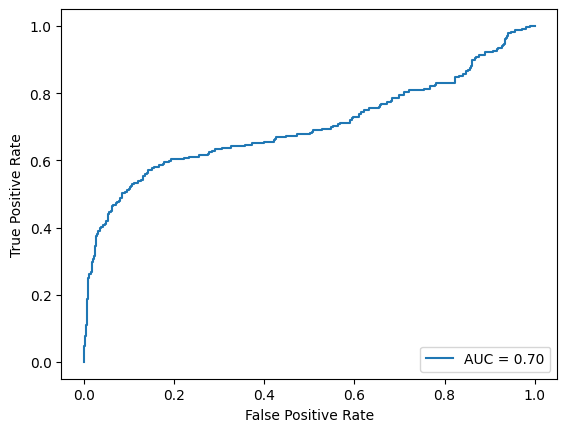

In [11]:
fpr, tpr, thresholds = roc_curve(Y_t[:,1], y_pred[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

In [ ]:
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), y_pred[:,1])), key=lambda i: i[0], reverse=True)[0][1]
optimal_proba_cutoff

In [ ]:
cutoff_labels = [int(i >= optimal_proba_cutoff) for i in y_pred[:,1]]

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Y_t[:,1],cutoff_labels).ravel()

confusion_matrix(Y_t[:,1],cutoff_labels)

In [63]:
precision_score(Y_t[:,1],cutoff_labels)

0.20945945945945946

In [64]:
recall_score(Y_t[:,1],cutoff_labels)

0.6768558951965066

In [65]:
accuracy_score(Y_t[:,1],cutoff_labels)

0.4593929450369155

In [66]:
f1_score(Y_t[:,1],cutoff_labels)

0.31991744066047473

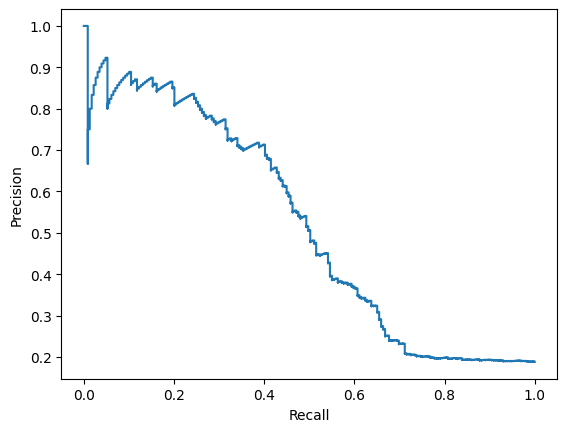

In [43]:
precision, recall, _ = precision_recall_curve(Y_t[:,1], y_pred[:,1])

disp = PrecisionRecallDisplay(precision = precision, recall = recall)
disp.plot()

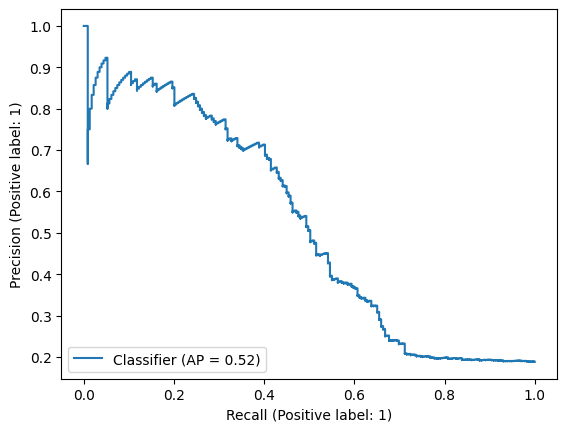

In [44]:
PrecisionRecallDisplay.from_predictions(Y_t[:,1], y_pred[:,1])
plt.show()